# Predicting informativeness
- This notebook shows how to use pre-trained ELMo embeddings to train the regression model.
- The dependent variable we want to predict is informativeness score, calculated based on human annotations.

# Importing libraries

In [5]:
import numpy as np
import pandas as pd
import os
import sys
import random
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

from keras.models import Sequential, Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import keras.layers as layers
import keras.backend as K
from keras.engine import Layer
from keras import regularizers, optimizers, metrics

Using TensorFlow backend.
W0511 00:44:39.974843 4444071360 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [8]:
import keras_tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from livelossplot.keras import PlotLossesCallback

In [7]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy, spearmanr
from scipy.stats import describe, ttest_ind

# Import cloze data 
- Note: data is not provided in this code sample repo

In [9]:
pd.set_option('display.max_colwidth', -1)
rdm_seed = 1
# tf.logging.set_verbosity(tf.logging.ERROR)

In [10]:
df_cloze = pd.read_pickle("./cloze_df_scores_all2.pickle")

In [11]:
df_cloze.head()

,Unnamed: 0,index,cloze_resp,sentID_GM,sentence,targ,targ_POS,cloze_resp_len,ent_elmo,ent_cloze,bert_score,glove_score,Unnamed: 0.1,sent_idx,scores,scores_sum,scores_avg,scores_std,scores_avg_rank,elmo_score
0,0,0,"{'fight': 8, 'rift': 6, 'wall': 2, 'wedge': 1, 'divide': 1, 'disagreement': 1, 'argument': 1, 'resentment': 1, 'chasm': 1, 'battle': 1, 'rivalry': 1, 'grudge': 1, 'third': 1, 'enmity': 1, 'split': 1, 'problem': 1, 'conflict': 1}",{1547},A ______ emerged between the two who were once friends .,{'discord'},NN,[30],2.246163,2.442118,0.724184,0.295388,954,954,"[0, -1, -1, 0, 0, 0, 0, 0, -1, 0, 1, 1, 0, 0, 0, 0, -1, 0, 1, 0, -1, 0, 0, -1]",-3,-0.125000,0.599479,678.5,0.594419
1,1,1,"{'happy': 6, 'unconventional': 2, 'simple': 2, 'peaceful': 2, 'wild': 2, 'adventurous': 2, 'fun': 2, 'whimsical': 1, 'carefree': 1, 'blast': 1, 'kind': 1, 'nice': 1, 'vibrant': 1, 'adventurer': 1, 'creative': 1, 'witty': 1, 'hipster': 1, 'optimist': 1, 'loving': 1}",{518},A bohemian is a person who is free-spirited and ______ .,{'rakish'},AJ,[30],2.232694,2.765587,0.675923,0.256244,71,71,"[0, 1, 1, 0, 0, 0, 1, 0, 0, -1, -1, 0, -1, 0, -1, 1, 0, 0, 0, 1, 0, -1, 0, 0]",0,0.000000,0.645497,842.0,0.542132
2,2,2,"{'stole': 13, 'stolen': 7, 'vandalized': 3, 'damaged': 2, 'tore': 1, 'ruined': 1, 'destroyed': 1, 'defaced': 1, 'defiled': 1}",{803},A bunch of kids had broken in and ______ the paintings .,{'defile'},VB,[30],2.243330,1.679603,0.896399,0.525470,694,694,"[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, -1, 0, 0, -1]",-1,-0.041667,0.538452,787.0,0.778024
3,3,3,"{'berate': 5, 'bully': 4, 'belittle': 3, 'insult': 3, 'push': 2, 'love': 1, 'punish': 1, 'abuse': 1, 'fear': 1, 'badger': 1, 'annoy': 1, 'criticisms': 1, 'dictatorship': 1, 'ridicule': 1, 'scold': 1, 'demoralize': 1, 'order': 1, 'mock': 1}",{747},"A coach should provide leadership, not ______ their players .",{'browbeat'},VB,[30],2.200604,2.682186,0.714305,0.232669,470,470,"[1, 0, 1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0, 0, 1, 0, 0, 1, 0, 0]",6,0.250000,0.595119,1237.5,0.663644
4,4,4,"{'force': 4, 'get': 3, 'whip': 2, 'bring': 2, 'start': 2, 'prod': 2, 'coach': 1, 'help': 1, 'coerce': 1, 'train': 1, 'lasso': 1, 'hit': 1, 'halt': 1, 'roundup': 1, 'slow': 1, 'coax': 1, 'lead': 1, 'make': 1, 'entice': 1, 'push': 1, 'order': 1}",{875},A cowboy used a short whip to ______ his horse into a slow gallop .,{'goad'},VB,[30],2.221154,2.921658,0.778465,0.250248,1351,1351,"[1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, -1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",8,0.333333,0.552771,1365.5,0.663699


## Prepairing the training/test data 

In [12]:
sent_cntx_l2r = []
sent_cntx_r2l = []
for sent in df_cloze['sentence']:
    sent = sent.replace("______", "[]")
    cntx = sent.split("[]")
#     sent_cntx.append([[cntx[0]], [cntx[1]]])
    sent_cntx_l2r.append([cntx[0].replace("<BOS>", "")]) #"<S>")])
    sent_cntx_r2l.append([cntx[1].replace("<EOS>", "")]) #"</S>")])
sent_cntx_l2r = np.array(sent_cntx_l2r)
sent_cntx_r2l = np.array(sent_cntx_r2l)

In [ ]:
mm_scaler = MinMaxScaler()

resp_scores = mm_scaler.fit_transform(df_cloze[['ent_cloze', 'elmo_score', 'scores_sum']])
# resp_lex = resp_scores[:, 0]
# resp_sem = resp_scores[:, 1]
resp_bws = resp_scores[:, 2]

/anaconda3/envs/infmtv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [ ]:
resp = [resp for responses in df_cloze["cloze_resp"] for resp in list(responses.keys())]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(resp)

resp_bws = df_cloze['scores_avg'].values

# train_idx = 400
random.seed(rdm_seed)
test_idx = random.sample(range(len(sent_cntx_l2r)), int(len(sent_cntx_l2r)*.20))

# training/test sentence contexts
sent_cntx_l2r_test  = [sent_cntx_l2r[i] for i in test_idx]
sent_cntx_r2l_test  = [sent_cntx_r2l[i] for i in test_idx]
sent_cntx_l2r_train = np.delete(sent_cntx_l2r, test_idx)
sent_cntx_r2l_train = np.delete(sent_cntx_r2l, test_idx)

# informative scores
resp_bws_test = [resp_bws[i] for i in test_idx]
resp_bws_train  = np.delete(resp_bws, test_idx)

# Model functions 
- First, we defined a custom class for ELMo embedding layers. 
- The output of this layer only takes partial information from the off-the-shelf ELMo embeddings, providing a single context vector
    - concatenation of L->R and R<-L context vectors on the target word

In [ ]:
# https://github.com/strongio/keras-elmo/blob/master/Elmo%20Keras.ipynb
class ElmoEmbeddingLayer(Layer):
    def __init__(self, direction, _trainable=True, **kwargs):
        self.dimensions = 1024
        self.trainable = _trainable
        self.direction = direction
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):        
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable, name="{}_module".format(self.name))
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)
        
    def call(self, x, mask=None):
        input_batch = K.squeeze(K.cast(x, tf.string), axis=1)
        result = self.elmo(input_batch,
                           as_dict=True,
                           signature='default',
                           )['elmo']#['elmo']#
        # using LSTM output for indexing: 
        ## TODO: but LSTM outputs still fail to create gradient flow;   e.g.,ValueError: An operation has `None` for gradient.
        ## in https://tfhub.dev/google/elmo/2 -- Restricted trainable variables to the 4 scalar weights as described in the paper.
        ## -> does it means that only 'elmo' layer is trainable with 4 scalar weights?
        ## -->> yes..? https://towardsdatascience.com/transfer-learning-using-elmo-embedding-c4a7e415103c
        result_lstm2 = self.elmo(input_batch, # to parse 0 vectors for padding
                           as_dict=True,
                           signature='default',
                           )['lstm_outputs2']
        
        # ELMo embedding index per direction: https://github.com/asafamr/SymPatternWSI
        ## first 512: forward; 512:1024: backward LM
        ## ELMo: right-side padding; e.g., -1: select the vector of the last token from the longest sentence only
        if(self.direction == 'forward'):
            last_idx = tf.not_equal(result_lstm2[:,:,-1], tf.constant(0, tf.float32)) # True:if the first value of the vector is not zero
            last_idx = tf.reduce_sum(tf.cast(last_idx, tf.int32), axis=1)-1 # last idx for non zero vector
            last_idx = tf.stack([tf.range(tf.shape(last_idx)[0]), last_idx], axis=1) # last idx as matrix
            result = tf.gather_nd(result[:,:,:512], last_idx)
#             result = layers.Lambda(lambda x:x[:,-1, :512])(result) #[:, :512])(result)
#             result = layers.Lambda(lambda x:x[:,:, :512])(result)
#             result = layers.Lambda(lambda x:result[:,x, :512])(result)
# #             result = layers.Lambda(lambda x:x[0][:, x[1][-1], :512])([result, input_batch]) #[:, :512])(result)
# #             result = tf.convert_to_tensor([result[i, input_len[i]-1, :512] for i in range(input_len.shape[0])])
        if(self.direction == 'backward'):
#             result = layers.Lambda(lambda x:x[:,0, 512:])(result) #[:, 512:])(result)
            result = result[:, 0, 512:]
            
        return result
    
    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')
    
    def compute_output_shape(self, input_shape):
#         return (input_shape[0], input_shape[0], int(self.dimensions/2))
        return (input_shape[0], int(self.dimensions/2))

- Second, we define the model structure
    - The finetuning model includes additional layers (e.g., dropout, ReLU) before the regression layer. 

In [ ]:
def dnn_notune(_lambda_exp=1.0):
    x_cntx_l2r = layers.Input((1,), name='input_cntx_l2r', dtype="string")
    x_cntx_r2l = layers.Input((1,), name='input_cntx_r2l', dtype="string")

    embed_l2r = ElmoEmbeddingLayer("forward",  _trainable=False)(x_cntx_l2r)
    embed_r2l = ElmoEmbeddingLayer("backward", _trainable=False)(x_cntx_r2l)
    embed_sent = layers.concatenate([embed_l2r, embed_r2l])

    output = layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l2(np.exp(_lambda_exp)))(embed_sent)

    model = Model([x_cntx_l2r, x_cntx_r2l], [output])
    adam = optimizers.Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=adam) 
    return(model)

In [ ]:
def dnn_finetune(_lambda_exp=1.0):
    x_cntx_l2r = layers.Input((1,), name='input_cntx_l2r', dtype="string")
    x_cntx_r2l = layers.Input((1,), name='input_cntx_r2l', dtype="string")

    embed_l2r = ElmoEmbeddingLayer("forward" , _trainable=True)(x_cntx_l2r)
    embed_r2l = ElmoEmbeddingLayer("backward", _trainable=True)(x_cntx_r2l)
    embed_l2r = layers.Dropout(0.3)(embed_l2r)
    embed_r2l = layers.Dropout(0.3)(embed_r2l)
    embed_sent = layers.concatenate([embed_l2r, embed_r2l])

    dnn = layers.Dense(512, activation='linear', kernel_initializer='normal')(embed_sent)
    dnn = layers.Dropout(0.2)(dnn)
    dnn = layers.Dense(128, activation='relu')(dnn)

    output = layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l2(np.exp(_lambda_exp)))(dnn)

    model = Model([x_cntx_l2r, x_cntx_r2l], [output])
    adam = optimizers.Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=adam) 
    return(model)

- Third, we define some helper functions for the cross validation process

In [ ]:
def train_mod_cv(train_l2r, train_r2l, train_y, modtype='finetune', 
                 _num_iter=300, _batch_size=128, _lambda_exp=1.0):
    mod = None
    if(modtype=='finetune'):
        mod = dnn_finetune(_lambda_exp)
    if(modtype=='notune'):
        mod = dnn_notune(_lambda_exp)
        
    mod.fit([train_l2r, train_r2l], 
            [train_y],
            epochs=_num_iter, batch_size=_batch_size, validation_split=0.10, shuffle=True,
            verbose=0, 
            callbacks=[#earlystop,  
                keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True),
                plot_losses])
    return(mod)

In [ ]:
def load_mod_cv(loc_weights, modtype='finetune'):
    mod_cv = []
    for f in sorted(os.listdir(loc_weights)):
        file_loc = loc_weights+f
        print('loading:', file_loc)
        
        mod = None
        if(modtype=='finetune'):
            mod = dnn_finetune()
        if(modtype=='notune'):
            mod = dnn_notune()
        mod.load_weights(file_loc)
        mod_cv.append(mod)
    return(mod_cv)

In [ ]:
def pred_mod_cv(mod_cv, pred_x_l2r, pred_x_r2l, pred_y, _batch_size):
    pred_res = np.reshape(mod_cv.predict([pred_x_l2r, pred_x_r2l], batch_size=_batch_size), -1)
    return([pred_res, pred_y])

- Lastly, hyperparameters

In [ ]:
_num_iter = 100
_batch_size = 128
k_folds = 5
_lambda_exp = [-3, -2, -1, 0, 1]

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=100, verbose=0, mode='auto', 
                          restore_best_weights=True)
plot_losses = PlotLossesCallback()

kf = KFold(n_splits=k_folds, random_state=rdm_seed)

# Fine-tuning DNN 
- This sample code only includes the results of finetuning model

## Fit Models - cv
- You can fit and predict across folds like this

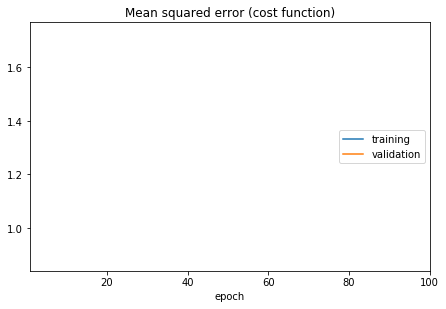

Mean squared error (cost function):
training   (min:    1.725, max:    1.725, cur:    1.725)
validation (min:    0.883, max:    0.883, cur:    0.883)


In [ ]:
for l in _lambda_exp:
    fold_idx = 0
    for train_idx, test_idx in kf.split(df_cloze):
        K.clear_session()
        print("fold:", fold_idx)
        # training
        temp_mod = train_mod_cv(sent_cntx_l2r[train_idx], sent_cntx_r2l[train_idx], resp_bws[train_idx], "finetune",
                                _num_iter, _batch_size, l)
        temp_mod.save_weights("output_dnn_cloze/finetune/bws/finetune_elmo_regression_"+"bws"+
                              "_i"+str(_num_iter)+"_b"+str(_batch_size)+"_l"+str(l)+
                              "_cv"+str(fold_idx)+".h5")

        # predicting
        temp_pred_test = pred_mod_cv(temp_mod, 
                                     sent_cntx_l2r[test_idx], sent_cntx_r2l[test_idx], 
                                     resp_bws[test_idx], _batch_size)
        np.save("output_dnn_cloze/finetune/bws/pred_res_"+"bws"+
                "_i"+str(_num_iter)+"_b"+str(_batch_size)+"_l"+str(l)+
                "_cv"+str(fold_idx)+".npy", temp_pred_test)

        fold_idx += 1    

In [ ]:
mod_b_cv = load_mod_cv("./output_dnn_cloze/finetune/bws/")

## Or use simple train/test split

In [65]:
K.clear_session()
mod_b = dnn_finetune()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver

In [32]:
_num_iter = 500
_batch_size = 64
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=100, verbose=0, mode='auto', 
                          restore_best_weights=True)
plot_losses = PlotLossesCallback()

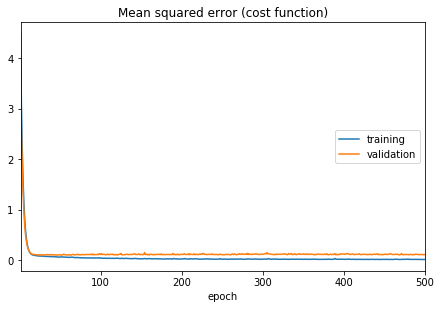

Mean squared error (cost function):
training   (min:    0.015, max:    4.480, cur:    0.015)
validation (min:    0.099, max:    3.508, cur:    0.109)


In [37]:
mod_b.fit([sent_cntx_l2r_train, sent_cntx_r2l_train], [resp_bws_train],
          epochs=_num_iter, batch_size=_batch_size, validation_split=0.10, shuffle=True,
          verbose=0, 
          callbacks=[#earlystop,  
                     keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True),
                     plot_losses])

- based on the loss graph, we only need a few iterations, but save the training result anyway.

In [38]:
mod_b.save_weights("output_dnn_cloze/finetune_elmo_regression_bws.h5")

# Prediction with train/test data 
- Using the simple train/test split

In [69]:
K.clear_session()
mod_b = dnn_finetune() 

mod_b.load_weights("output_dnn_cloze/finetune_elmo_regression_bws.h5")

## Predicting the train data
- Checks if the training occured? 
- If overfits: something has happened

In [70]:
ent_pred_train_b = np.reshape(mod_b.predict([sent_cntx_l2r_train, sent_cntx_r2l_train], batch_size=_batch_size), -1)

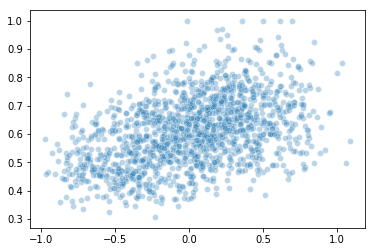

In [75]:
sns.scatterplot(ent_pred_train_b, resp_bws_train, alpha=0.3)

In [76]:
spearmanr(ent_pred_train_b, resp_bws_train)# resp_ent_train)

SpearmanrResult(correlation=0.43274677056072625, pvalue=3.343740446192777e-66)

## Predicting the test data
- Here we see the actual prediction
- measurement: Spearman correlation between the data and predicted value

In [77]:
ent_pred_test_b  = np.reshape(mod_b.predict([sent_cntx_l2r_test, sent_cntx_r2l_test], batch_size=_batch_size), -1)

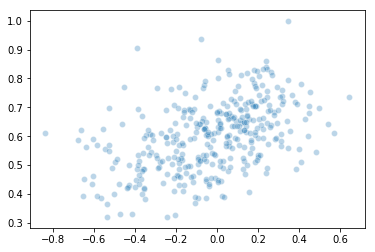

In [82]:
sns.scatterplot(ent_pred_test_b, resp_bws_test, alpha=0.3)

In [83]:
spearmanr(ent_pred_test_b, resp_bws_test)

SpearmanrResult(correlation=0.4875532108713085, pvalue=1.1769258620547542e-22)

## Doublechecking if the original dependent variable was the random variable

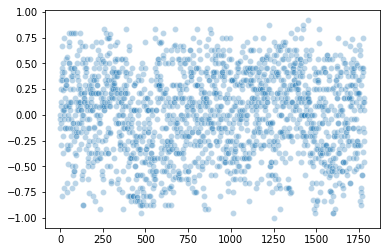

In [86]:
sns.scatterplot(np.arange(len(resp_bws)), resp_bws, alpha=0.3)